In [1]:
import gdown
import zipfile
import os
import shutil
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [2]:
# Downloading zipped data from drive

file_id = "1rHKiveyklxUdu5WWCfAPMvbFiBmAgDuB"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "FinalData.zip", quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1rHKiveyklxUdu5WWCfAPMvbFiBmAgDuB
From (redirected): https://drive.google.com/uc?id=1rHKiveyklxUdu5WWCfAPMvbFiBmAgDuB&confirm=t&uuid=8942c59b-2ee9-4b2a-b871-3c7be74c32d9
To: /content/FinalData.zip
100%|██████████| 403M/403M [00:07<00:00, 55.0MB/s]


'FinalData.zip'

In [3]:
# Unzipping data

print("Unzipping...")
with zipfile.ZipFile("FinalData.zip", "r") as z:
    z.extractall("dataset")

print("Done!")


Unzipping...
Done!


In [4]:

# ---------------- CONFIG ----------------
raw_folder = "dataset/FinalData"
cnn_base_folder = "dataset/cnn_ready_split"
img_formats = (".png", ".jpg", ".jpeg")
splits = {"train": 0.8, "val": 0.1, "test": 0.1}
payload_ratio = 0.5  # 50% of all LSBs will be embedded

# ---------------- CLEAN EXISTING CNN FOLDER ----------------
if os.path.exists(cnn_base_folder):
    shutil.rmtree(cnn_base_folder)

# ---------------- CREATE FOLDER STRUCTURE ----------------
for split in ["train", "val", "test"]:
    for cls in ["raw", "lsb"]:
        os.makedirs(os.path.join(cnn_base_folder, split, cls), exist_ok=True)


In [5]:
# ---------------- LSB EMBEDDING FUNCTION ----------------
def embed_lsb(img_path, payload_ratio=0.5):

    img = Image.open(img_path)
    if img.mode != "RGB":
        img = img.convert("RGB")
    arr = np.array(img, dtype=np.uint8)
    flat_arr = arr.flatten()

    num_pixels = flat_arr.size
    num_bits_to_embed = int(num_pixels * payload_ratio)


    msg_bits = np.random.randint(0, 2, num_bits_to_embed)


    flat_arr[:num_bits_to_embed] = (flat_arr[:num_bits_to_embed] & 0xFE) | msg_bits

    new_arr = flat_arr.reshape(arr.shape)
    return Image.fromarray(new_arr)

In [6]:

# ---------------- SPLIT AND COPY ----------------
imgs = [f for f in os.listdir(raw_folder) if f.lower().endswith(img_formats)]

train_imgs, temp_imgs = train_test_split(imgs, test_size=splits["val"] + splits["test"], random_state=42)
val_imgs, test_imgs = train_test_split(temp_imgs, test_size=splits["test"] / (splits["val"] + splits["test"]), random_state=42)

split_dict = {"train": train_imgs, "val": val_imgs, "test": test_imgs}

for split_name, split_imgs in split_dict.items():
    for img_file in split_imgs:
        raw_path = os.path.join(raw_folder, img_file)

        # COPY RAW IMAGE
        shutil.copy(raw_path, os.path.join(cnn_base_folder, split_name, "raw", img_file))

        # CREATE LSB IMAGE
        lsb_img = embed_lsb(raw_path, payload_ratio=payload_ratio)
        lsb_img.save(os.path.join(cnn_base_folder, split_name, "lsb", img_file))

print(" Dataset prepared with train/val/test splits and LSB embedded (0.5 payload).")


 Dataset prepared with train/val/test splits and LSB embedded (0.5 payload).


In [7]:
# ---------------- CONFIG ----------------
cnn_base_folder = "dataset/cnn_ready_split"
img_height, img_width = 224, 224
batch_size = 32
initial_epochs = 20
fine_tune_epochs = 20
model_save_path = "lsb_mobilenetv2_model.h5"

In [8]:
train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(cnn_base_folder, "train"),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed=42
)

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(cnn_base_folder, "val"),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(cnn_base_folder, "test"),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 18586 images belonging to 2 classes.
Found 2324 images belonging to 2 classes.
Found 2324 images belonging to 2 classes.


In [9]:

# ---------------- BUILD MODEL ----------------
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base model initially

inputs = Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [10]:
# ---------------- TRAIN MODEL (INITIAL) ----------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=initial_epochs,
    verbose=1
)


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


581/581 ━━━━━━━━━━━━━━━━━━━━ 83s 113ms/step - accuracy: 0.5839 - loss: 0.7096 - val_accuracy: 0.7315 - val_loss: 0.5625
Epoch 2/20
581/581 ━━━━━━━━━━━━━━━━━━━━ 35s 61ms/step - accuracy: 0.6956 - loss: 0.5936 - val_accuracy: 0.7362 - val_loss: 0.5521
Epoch 3/20
581/581 ━━━━━━━━━━━━━━━━━━━━ 35s 60ms/step - accuracy: 0.7028 - loss: 0.5794 - val_accuracy: 0.7444 - val_loss: 0.5421
Epoch 4/20
581/581 ━━━━━━━━━━━━━━━━━━━━ 35s 60ms/step - accuracy: 0.6987 - loss: 0.5815 - val_accuracy: 0.7401 - val_loss: 0.5431
Epoch 5/20
581/581 ━━━━━━━━━━━━━━━━━━━━ 36s 61ms/step - accuracy: 0.7086 - loss: 0.5769 - val_accuracy: 0.7453 - val_loss: 0.5384
Epoch 6/20
581/581 ━━━━━━━━━━━━━━━━━━━━ 35s 61ms/step - accuracy: 0.7056 - loss: 0.5775 - val_accuracy: 0.7539 - val_loss: 0.5362
Epoch 7/20
581/581 ━━━━━━━━━━━━━━━━━━━━ 37s 64ms/step - accuracy: 0.7089 - loss: 0.5762 - val_accuracy: 0.7552 - val_loss: 0.5385
Epoch 8/20
581/581 ━━━━━━━━━━━━━━━━━━━━ 34s 58ms/step - accuracy: 0.7083 - loss: 0.5775 - val_accura

In [11]:
# ---------------- FINE-TUNE ----------------
base_model.trainable = True
fine_tune_at = 80  # Unfreeze from this layer

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower learning rate for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=initial_epochs + fine_tune_epochs,
    initial_epoch=history.epoch[-1] + 1,
    verbose=1
)

Epoch 21/40
581/581 ━━━━━━━━━━━━━━━━━━━━ 86s 103ms/step - accuracy: 0.7497 - loss: 0.5162 - val_accuracy: 0.8188 - val_loss: 0.4217
Epoch 22/40
581/581 ━━━━━━━━━━━━━━━━━━━━ 38s 65ms/step - accuracy: 0.8246 - loss: 0.3812 - val_accuracy: 0.8382 - val_loss: 0.3650
Epoch 23/40
581/581 ━━━━━━━━━━━━━━━━━━━━ 39s 66ms/step - accuracy: 0.8510 - loss: 0.3272 - val_accuracy: 0.8219 - val_loss: 0.3935
Epoch 24/40
581/581 ━━━━━━━━━━━━━━━━━━━━ 38s 65ms/step - accuracy: 0.8743 - loss: 0.2771 - val_accuracy: 0.8632 - val_loss: 0.3032
Epoch 25/40
581/581 ━━━━━━━━━━━━━━━━━━━━ 38s 66ms/step - accuracy: 0.8811 - loss: 0.2508 - val_accuracy: 0.8718 - val_loss: 0.2826
Epoch 26/40
581/581 ━━━━━━━━━━━━━━━━━━━━ 38s 65ms/step - accuracy: 0.8950 - loss: 0.2260 - val_accuracy: 0.8718 - val_loss: 0.2890
Epoch 27/40
581/581 ━━━━━━━━━━━━━━━━━━━━ 39s 66ms/step - accuracy: 0.9036 - loss: 0.2122 - val_accuracy: 0.8744 - val_loss: 0.2817
Epoch 28/40
581/581 ━━━━━━━━━━━━━━━━━━━━ 38s 65ms/step - accuracy: 0.9139 - loss: 

In [12]:

# ---------------- SAVE MODEL ----------------
model.save(model_save_path)
print(f"Model saved as {model_save_path}")

Model saved as lsb_mobilenetv2_model.h5


In [13]:
# ---------------- EVALUATION FUNCTION ----------------
def evaluate_model(gen, split_name="Validation"):
    gen.reset()
    preds_prob = model.predict(gen)
    preds = (preds_prob > 0.5).astype(int).reshape(-1)
    y_true = gen.classes

    acc = accuracy_score(y_true, preds)
    prec = precision_score(y_true, preds, zero_division=0)
    rec = recall_score(y_true, preds, zero_division=0)
    f1 = f1_score(y_true, preds, zero_division=0)

    print(f"\n--- {split_name} Metrics ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, preds, zero_division=0))

    cm = confusion_matrix(y_true, preds)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{split_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


In [14]:
# ---------------- PLOT TRAINING HISTORY ----------------
def plot_history(histories, initial_epochs, fine_tune_epochs):
    acc = histories['initial'].history['accuracy'] + histories['fine'].history['accuracy']
    val_acc = histories['initial'].history['val_accuracy'] + histories['fine'].history['val_accuracy']

    loss = histories['initial'].history['loss'] + histories['fine'].history['loss']
    val_loss = histories['initial'].history['val_loss'] + histories['fine'].history['val_loss']

    epochs_range = range(initial_epochs + fine_tune_epochs)

    plt.figure(figsize=(8,4))
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()


73/73 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step

--- Validation Metrics ---
Accuracy: 0.9144
Precision: 0.9280
Recall: 0.8985
F1 Score: 0.9130

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      1162
           1       0.93      0.90      0.91      1162

    accuracy                           0.91      2324
   macro avg       0.91      0.91      0.91      2324
weighted avg       0.91      0.91      0.91      2324



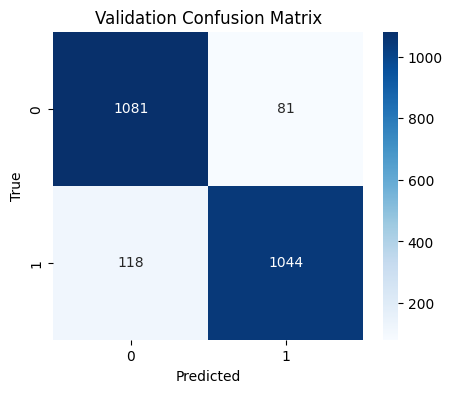

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step

--- Test Metrics ---
Accuracy: 0.9178
Precision: 0.9139
Recall: 0.9225
F1 Score: 0.9182

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      1162
           1       0.91      0.92      0.92      1162

    accuracy                           0.92      2324
   macro avg       0.92      0.92      0.92      2324
weighted avg       0.92      0.92      0.92      2324



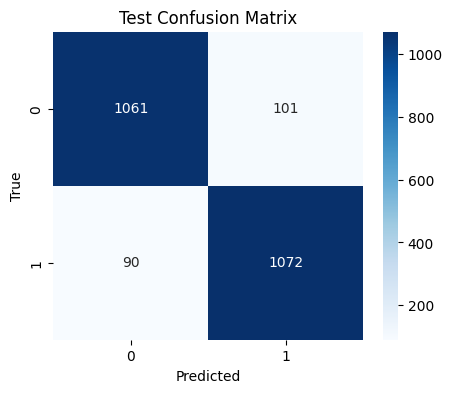

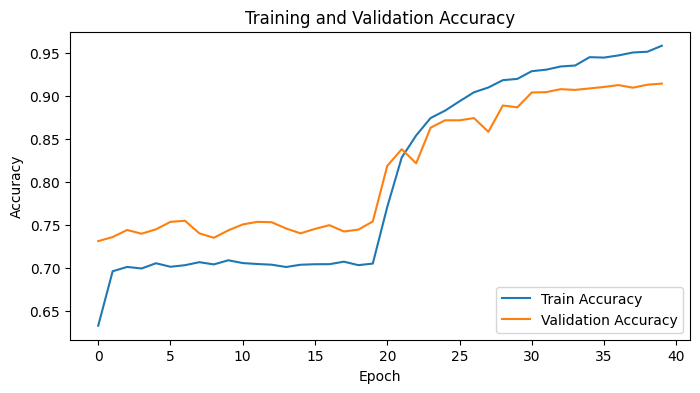

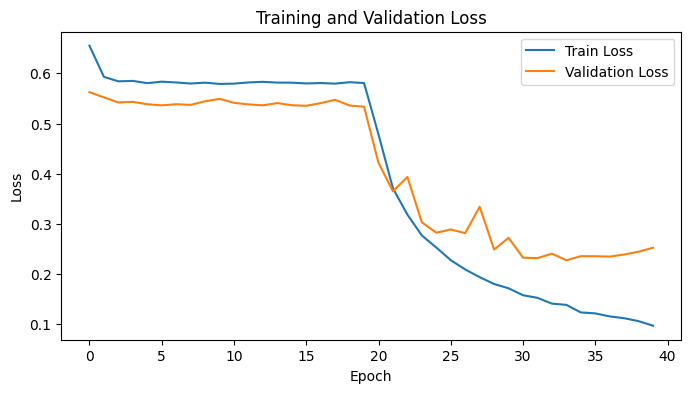


--- TRAINING AND EVALUATION COMPLETE ---


In [15]:

# ---------------- RUN EVALUATION AND PLOTS ----------------
evaluate_model(val_gen, split_name="Validation")
evaluate_model(test_gen, split_name="Test")

plot_history({'initial': history, 'fine': history_fine}, initial_epochs, fine_tune_epochs)

print("\n--- TRAINING AND EVALUATION COMPLETE ---")